In [ ]:
## Setting up the Environment:

In [196]:
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [197]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import lower, col
from pyspark.sql import functions as sf
from pyspark.sql.functions import to_timestamp
import matplotlib.pyplot as plt

In [198]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
#%pip uninstall nltk
%pip install nltk -U
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [199]:
warnings.filterwarnings(action='ignore')
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [ ]:
# pip install nltk -U

In [ ]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

In [ ]:
# %%time
# !hadoop fs -ls "gs://msca-bdp-tweets/final_project"

In [155]:
## Loading the Data:
twitter = spark.read.json("gs://msca-bdp-tweets/final_project")

22/12/05 03:13:02 WARN org.apache.spark.sql.execution.datasources.SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
22/12/05 03:18:42 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
# Showing basic information about the twitter data:

In [15]:
twitter.limit(20)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_copyright,withheld_in_countries
null,Wed May 25 14:52:...,null,"{[], null, [], [{...",null,"{[0, 276], {[{[19...",0,false,low,null,1529475553572560898,1529475553572560898,null,null,null,null,null,false,en,null,false,0,null,null,null,null,null,0,0,,Autoweek’s @AWJay...,null,"<a href=""https://...",Postal vehicles m...,1653490362910,true,Postal vehicles m...,"{false, Thu Jul 1...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475553862070272,1529475553862070272,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,KXAN_News,"{null, Wed May 25...","<a href=""http://t...",RT @KXAN_News: “T...,1653490362979,false,“The sweetest lit...,"{false, Mon Dec 2...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475553664946182,1529475553664946182,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,leslibless,"{null, Tue May 24...","<a href=""https://...",RT @leslibless: A...,1653490362932,false,Apparently this g...,"{false, Thu Apr 1...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475556982800386,1529475556982800386,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,thetaeprint,"{null, Wed May 25...","<a href=""http://t...",RT @thetaeprint: ...,1653490363723,false,[INFO] MBC news r...,"{false, Sat Sep 0...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475556965761025,1529475556965761025,null,null,null,null,null,true,en,null,null,0,"{null, Mon May 23...",1528600478182825989,1528600478182825989,{twitter.com/uzia...,Here’s a new 2022...,0,0,RT,TheHumanDurag,"{null, Tue May 24...","<a href=""http://t...",RT @TheHumanDurag...,1653490363719,false,You 30 years old....,"{false, Tue Aug 1...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557255045121,1529475557255045121,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,davidhogg111,"{null, Wed May 25...","<a href=""https://...",RT @davidhogg111:...,1653490363788,false,I want my future ...,"{false, Thu Mar 0...",null,null
null,Wed May 25 14:52:...,"[12, 140]","{[], null, [], [{...",null,"{[12, 282], {[], ...",0,false,low,null,1529475557158789121,1529475557158789121,benshapiro,1529433100354211840,1529433100354211840,17995040,17995040,false,en,null,null,0,null,null,null,null,null,0,0,,null,null,"<a href=""https://...",@benshapiro UPD d...,1653490363765,true,@benshapiro UPD d...,"{false, Tue Jun 0...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557666193410,1529475557666193410,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,ShanePaulNeil,"{null, Wed May 25...","<a href=""http://t...",RT @ShanePaulNeil...,1653490363886,false,My town has annou...,"{false, Tue Jul 1...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557544673280,1529475557544673280,null,null,null,null,null,true,en,null,null,0,"{null, Mon May 16...",1526237750277681154,1526237750277681154,{twitter.com/dani...,Train up a child ...,0,0,RT,AliceAvizandum,"{null, Wed May 25...","<a href=""http://t...",RT @AliceAvizandu...,1653490363857,false,Today’s school sh...,"{false, Thu Dec 0...",null,null
null,Wed May 25 14:52:...,null,"{[], null, [], []...",

In [80]:
twitter.printSchema()

root
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |   

In [10]:
twitter.schema.names

['coordinates',
 'created_at',
 'display_text_range',
 'entities',
 'extended_entities',
 'extended_tweet',
 'favorite_count',
 'favorited',
 'filter_level',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_count',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status_permalink',
 'quoted_text',
 'reply_count',
 'retweet_count',
 'retweeted',
 'retweeted_from',
 'retweeted_status',
 'source',
 'text',
 'timestamp_ms',
 'truncated',
 'tweet_text',
 'user',
 'withheld_copyright',
 'withheld_in_countries',
 'lowered_text']

In [8]:
twitter.count()

99992797

In [ ]:
## 1. Discard irrelevant tweets (you can expect a significant number of tweets to be eliminated)

In [157]:
# Filtering for text that is related to education topic based on education-related key words:
twitter = twitter.withColumn("lowered_text", lower(col("text")))
filtered = twitter.filter(twitter.lowered_text.contains('school')\
                          |twitter.lowered_text.contains('learn')\
                          |twitter.lowered_text.contains('knowledge')\
                          |twitter.lowered_text.contains('college')\
                          |twitter.lowered_text.contains('kids')\
                          |twitter.lowered_text.contains('university')\
                          |twitter.lowered_text.contains('professor')\
                          |twitter.lowered_text.contains('children')\
                          |twitter.lowered_text.contains('child')\
                          |twitter.lowered_text.contains('higher')\
                          |twitter.lowered_text.contains('secondary')\
                          |twitter.lowered_text.contains('primary')\
                          |twitter.lowered_text.contains('public')\
                          |twitter.lowered_text.contains('education')\
                          |twitter.lowered_text.contains('elementary')\
                          |twitter.lowered_text.contains('class')\
                          |twitter.lowered_text.contains('student')\
                          |twitter.lowered_text.contains('course')\
                          |twitter.lowered_text.contains('degree')\
                          |twitter.lowered_text.contains('department')\
                          |twitter.lowered_text.contains('private'))

In [6]:
## 2.Complete thorough EDA to identify which variables you can use to profile the Twitterers
## A lot of variables are poorly populated and will have to be discarded

In [ ]:
# pd.set_option('max_colwidth', 50000)

In [ ]:
# Show some unsure varaibles that could not be comprehend by reading the schema and decide if to keep them:

In [158]:
filtered.withColumn('year', substring('created_at', 27,4)).groupby("year").count().limit(20).toPandas()

22/12/05 03:33:23 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670137085848_0007_01_000030 on host: hub-msca-bdp-dphub-students-backup-tianze-sw-tsvh.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-05 03:33:23.635]Container killed on request. Exit code is 143
[2022-12-05 03:33:23.636]Container exited with a non-zero exit code 143. 
[2022-12-05 03:33:23.636]Killed by external signal
.
22/12/05 03:33:23 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1670137085848_0007_01_000029 on host: hub-msca-bdp-dphub-students-backup-tianze-sw-tsvh.c.msca-bdp-students.internal. Exit status: 143. Diagnostics: [2022-12-05 03:33:23.636]Container killed on request. Exit code is 143
[2022-12-05 03:33:23.636]Container exited with a non-zero exit code 143. 
[2022-12-05 03:33:23.637]Killed by external signal
.
22/12/05 03:33:23 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoi

,year,count
0,2022,81496566


In [ ]:
filtered.filter(col("coordinates").isNotNull()).count()

97554

In [7]:
filtered.groupby('place').count().limit(20).toPandas()

,place,count
0,"(([[[-119.080552, 36.029555], [-119.080552, 36.119995], [-118.977713, 36.119995], [-118.977713, 36.029555]]], Polygon), United States, US, Porterville, CA, daa5fcec75a430ae, Porterville, city, https://api.twitter.com/1.1/geo/id/daa5fcec75a430ae.json)",60
1,"(([[[-3.640637, 52.947131], [-3.640637, 55.188879], [-1.909626, 55.188879], [-1.909626, 52.947131]]], Polygon), United Kingdom, GB, North West, England, 0cbfb5dccb8131b8, North West, admin, https://api.twitter.com/1.1/geo/id/0cbfb5dccb8131b8.json)",641
2,"(([[[176.84555, -39.64499], [176.84555, -39.64499], [176.84555, -39.64499], [176.84555, -39.64499]]], Polygon), New Zealand, NZ, Toitoi: Hawke's Bay Arts & Events Centre, 112be4377f945000, Toitoi: Hawke's Bay Arts & Events Centre, poi, https://api.twitter.com/1.1/geo/id/112be4377f945000.json)",1
3,"(([[[-97.028288, 32.541286], [-97.028288, 32.649242], [-96.891039, 32.649242], [-96.891039, 32.541286]]], Polygon), United States, US, Cedar Hill, TX, 4233ec320eb73634, Cedar Hill, city, https://api.twitter.com/1.1/geo/id/4233ec320eb73634.json)",56
4,"(([[[25.406293, -34.050498], [25.406293, -33.764626], [25.704339, -33.764626], [25.704339, -34.050498]]], Polygon), South Africa, ZA, Port Elizabeth, South Africa, 0e428116fe291283, Port Elizabeth, city, https://api.twitter.com/1.1/geo/id/0e428116fe291283.json)",167
5,"(([[[-90.418108, 41.696088], [-90.418108, 48.306272], [-82.122971, 48.306272], [-82.122971, 41.696088]]], Polygon), United States, US, Michigan, USA, 67d92742f1ebf307, Michigan, admin, https://api.twitter.com/1.1/geo/id/67d92742f1ebf307.json)",1918
6,"(([[[-71.255046, 42.598237], [-71.255046, 42.700233], [-71.075953, 42.700233], [-71.075953, 42.598237]]], Polygon), United States, US, Andover, MA, 00a4b217142e93d0, Andover, city, https://api.twitter.com/1.1/geo/id/00a4b217142e93d0.json)",51
7,"(([[[23.812774, 35.403849], [23.812774, 35.535471], [23.921664, 35.535471], [23.921664, 35.403849]]], Polygon), Greece, GR, Platanias, Greece, 00424bae534baf9a, Platanias, city, https://api.twitter.com/1.1/geo/id/00424bae534baf9a.json)",3
8,"(([[[-8.632309, 42.82373], [-8.632309, 42.990113], [-8.389983, 42.990113], [-8.389983, 42.82373]]], Polygon), Espanha, ES, Santiago de Compostela, España, 1115004c3fafaf8a, Santiago de Compostela, city, https://api.twitter.com/1.1/geo/id/1115004c3fafaf8a.json)",2
9,"(([[[-80.147162, 25.761308], [-80.147162, 25.872623], [-80.118763, 25.872623], [-80.118763, 25.761308]]], Polygon), United States, US, Miami Beach, FL, 0121b92345f0e2b4, Miami Beach, city, https://api.twitter.com/1.1/geo/id/0121b92345f0e2b4.json)",262


In [8]:
filtered.groupby('lang').count().limit(20).toPandas()

,lang,count
0,en,81496566


In [10]:
# Bad retweet count data:
filtered.groupby('retweet_count').count().limit(20).toPandas()

,retweet_count,count
0,0,81496566


In [ ]:
filtered.groupby('retweeted_status').count().limit(20).toPandas()

retweeted_status  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
filtered.groupby('created_at').count().limit(20).toPandas()

,created_at,count
0,Wed May 25 02:35:11 +0000 2022,5
1,Sat Nov 05 21:30:39 +0000 2022,3
2,Sat Nov 05 21:32:53 +0000 2022,4
3,Fri Jun 10 10:58:50 +0000 2022,2
4,Tue May 24 23:12:42 +0000 2022,13
5,Tue May 24 23:35:30 +0000 2022,13
6,Tue Aug 30 19:08:38 +0000 2022,7
7,Wed May 25 03:01:53 +0000 2022,19
8,Wed May 25 03:04:12 +0000 2022,17
9,Sun Oct 09 21:47:12 +0000 2022,2


In [15]:
filtered.count()

81496566

In [16]:
filtered.limit(20)

coordinates,created_at,display_text_range,entities,extended_entities,extended_tweet,favorite_count,favorited,filter_level,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,quote_count,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_text,reply_count,retweet_count,retweeted,retweeted_from,retweeted_status,source,text,timestamp_ms,truncated,tweet_text,user,withheld_copyright,withheld_in_countries,lowered_text
null,Wed May 25 14:52:...,null,"{[], null, [], [{...",null,"{[0, 276], {[{[19...",0,false,low,null,1529475553572560898,1529475553572560898,null,null,null,null,null,false,en,null,false,0,null,null,null,null,null,0,0,,Autoweek’s @AWJay...,null,"<a href=""https://...",Postal vehicles m...,1653490362910,true,Postal vehicles m...,"{false, Thu Jul 1...",null,null,postal vehicles m...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475556965761025,1529475556965761025,null,null,null,null,null,true,en,null,null,0,"{null, Mon May 23...",1528600478182825989,1528600478182825989,{twitter.com/uzia...,Here’s a new 2022...,0,0,RT,TheHumanDurag,"{null, Tue May 24...","<a href=""http://t...",RT @TheHumanDurag...,1653490363719,false,You 30 years old....,"{false, Tue Aug 1...",null,null,rt @thehumandurag...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557255045121,1529475557255045121,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,davidhogg111,"{null, Wed May 25...","<a href=""https://...",RT @davidhogg111:...,1653490363788,false,I want my future ...,"{false, Thu Mar 0...",null,null,rt @davidhogg111:...
null,Wed May 25 14:52:...,"[12, 140]","{[], null, [], [{...",null,"{[12, 282], {[], ...",0,false,low,null,1529475557158789121,1529475557158789121,benshapiro,1529433100354211840,1529433100354211840,17995040,17995040,false,en,null,null,0,null,null,null,null,null,0,0,,null,null,"<a href=""https://...",@benshapiro UPD d...,1653490363765,true,@benshapiro UPD d...,"{false, Tue Jun 0...",null,null,@benshapiro upd d...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557666193410,1529475557666193410,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,ShanePaulNeil,"{null, Wed May 25...","<a href=""http://t...",RT @ShanePaulNeil...,1653490363886,false,My town has annou...,"{false, Tue Jul 1...",null,null,rt @shanepaulneil...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557544673280,1529475557544673280,null,null,null,null,null,true,en,null,null,0,"{null, Mon May 16...",1526237750277681154,1526237750277681154,{twitter.com/dani...,Train up a child ...,0,0,RT,AliceAvizandum,"{null, Wed May 25...","<a href=""http://t...",RT @AliceAvizandu...,1653490363857,false,Today’s school sh...,"{false, Thu Dec 0...",null,null,rt @aliceavizandu...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475557834072064,1529475557834072064,null,null,null,null,null,false,en,null,null,0,null,null,null,null,null,0,0,RT,MikeBloomberg,"{null, Wed May 25...","<a href=""http://t...",RT @MikeBloomberg...,1653490363926,false,At least 19 schoo...,"{false, Fri May 0...",null,null,rt @mikebloomberg...
null,Wed May 25 14:52:...,"[11, 140]","{[], null, [], [{...",null,"{[11, 233], {[], ...",0,false,low,null,1529475558257504257,1529475558257504257,DanRather,1529219204750094336,1529219204750094336,36711022,36711022,false,en,null,null,0,null,null,null,null,null,0,0,,null,null,"<a href=""http://t...",@DanRather can we...,1653490364027,true,@DanRather can we...,"{false, Tue Aug 1...",null,null,@danrather can we...
null,Wed May 25 14:52:...,null,"{[], null, [], []...",null,null,0,false,low,null,1529475558303596545,1529475558303596545,null,null,null,null,null,false,en,null,null,0,null,null,null

In [45]:
# Romoving unhelpful coloumns that contains multipy unused json files based on the variable name and its schema:
# (No worries if did not drop everything, will use "select" function to furthur refine the data set)

dropped = filtered.drop("coordinates",
                       "display_text_range",
                       "entities",
                       "extended_entities",
                       "favorited",
                       "filter_level",
                       "id",
                       "in_reply_to_status_id",
                       "in_reply_to_user_id",
                       "is_quote_status",
                       "lang",
                       "possibly_sensitive",
                       "quoted_status",
                       "quoted_status_id",
                       "quoted_status_permalink",
                       "quoted_text",
                       "retweeted",
                       "withheld_copyright",
                       "withheld_in_countries",
                       "source",
                       "in_reply_to_screen_name",
                       "in_reply_to_status_id_str",
                       "in_reply_to_user_id_str",
                       "favorite_count",
                       "geo",
                       "truncated",
                       "tweet_text",
                       "text",
                       "extended_tweet",
                       "retweet_count",
                       "reply_count")

In [12]:
dropped.limit(20)

created_at,id_str,place,quote_count,quoted_status_id_str,reply_count,retweet_count,retweeted_from,retweeted_status,timestamp_ms,user,lowered_text
Mon May 30 14:27:...,1531281252451356672,null,0,null,0,0,LJNFEED,"{null, Mon May 30...",1653920875071,"{false, Mon Feb 2...",rt @ljnfeed: #jen...
Mon May 30 14:27:...,1531281252900188161,null,0,null,0,0,SofiIshtiaq,"{null, Thu May 26...",1653920875178,"{false, Fri May 1...",rt @sofiishtiaq: ...
Mon May 30 14:27:...,1531281255115157506,null,0,null,0,0,null,null,1653920875706,"{false, Sat Mar 2...",china's education...
Mon May 30 14:27:...,1531281255882432514,null,0,null,0,0,kwameaddoobiri_,"{null, Sun May 29...",1653920875889,"{false, Tue May 0...",rt @kwameaddoobir...
Mon May 30 14:27:...,1531281257480343553,null,0,null,0,0,null,null,1653920876270,"{false, Fri Jul 3...",@gloss_077 um...l...
Mon May 30 14:27:...,1531281257866227713,null,0,null,0,0,null,null,1653920876362,"{false, Fri Dec 1...",lucknow universit...
Mon May 30 14:27:...,1531281257815887873,null,0,null,0,0,SallyMayweather,"{null, Sat May 28...",1653920876350,"{false, Sun May 3...",rt @sallymayweath...
Mon May 30 14:27:...,1531281258180845568,null,0,null,0,0,null,null,1653920876437,"{false, Mon May 3...",when the stem str...
Mon May 30 14:27:...,1531281258306732034,null,0,null,0,0,null,null,1653920876467,"{false, Tue Feb 0...",mans mentioning w...
Mon May 30 14:27:...,1531281259988672514,null,0,null,0,0,TPostMillennial,"{null, Mon May 30...",1653920876868,"{false, Sat Jul 0...",rt @tpostmillenni...


In [20]:
dropped.count()

81496566

In [13]:
dropped.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- place: struct (nullable = true)
 |    |-- bounding_box: struct (nullable = true)
 |    |    |-- coordinates: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |    |-- element: double (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |-- country: string (nullable = true)
 |    |-- country_code: string (nullable = true)
 |    |-- full_name: string (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- place_type: string (nullable = true)
 |    |-- url: string (nullable = true)
 |-- quote_count: long (nullable = true)
 |-- quoted_status_id_str: string (nullable = true)
 |-- reply_count: long (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- retweeted_

In [22]:
dropped.schema.names

['created_at',
 'id_str',
 'place',
 'quote_count',
 'quoted_status_id_str',
 'reply_count',
 'retweet_count',
 'retweeted_from',
 'retweeted_status',
 'timestamp_ms',
 'user',
 'lowered_text']

In [ ]:
dropped.describe()

summary,created_at,id_str,quote_count,quoted_status_id_str,reply_count,retweet_count,retweeted_from,timestamp_ms,lowered_text
count,81496566,81496566,81496566,6893536,81496566,81496566,57405110,81496566,81496566
mean,null,1.550732599036186...,0.0,1.546039065375552...,0.0,0.0,NaN,1.658558437485347...,null
stddev,null,2.274453679718122...,0.0,5.761365436403144...,0.0,0.0,NaN,5.422720145501064E9,null
min,Fri Apr 08 00:00:...,1511197334218096642,0,100,0,0,,1649132495823,! *he turns and ...
max,Wed Sep 28 23:59:...,1589390485495611392,0,999964504963387393,0,0,🥴 😩 #admin,1667775195846,󠇰 󠇰 󠇰 󠇰 prof...


In [47]:
# Refining useful data from the dropped data frame to get only useful information:
# (Additional useful information could be retrieved from json subset data)

cleaned = dropped.select([dropped.created_at,
                          dropped.id_str,
                          dropped.user['name'].alias('user_name'),
                          dropped.user['description'].alias('user_description'),
                          dropped.user['screen_name'].alias('user_screen_name'),
                          dropped.user['location'].alias('user_location'),
                          dropped.place['full_name'].alias('place_location'),
                          dropped.place['country'].alias('place_country'),
                          dropped.quoted_status_id_str,
                          dropped.retweeted_status['retweet_count'].alias('retweet_count'),
                          dropped.retweeted_status['retweeted'].alias('retweeted'),
                          dropped.lowered_text,
                          dropped.retweeted_from,
                          dropped.timestamp_ms])

In [ ]:
cleaned.count()

81496566

In [48]:
cleaned.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- place_location: string (nullable = true)
 |-- place_country: string (nullable = true)
 |-- quoted_status_id_str: string (nullable = true)
 |-- retweet_count: long (nullable = true)
 |-- retweeted: boolean (nullable = true)
 |-- lowered_text: string (nullable = true)
 |-- retweeted_from: string (nullable = true)
 |-- timestamp_ms: string (nullable = true)



In [ ]:
cleaned.describe()

In [ ]:
# Saving the refined data for a faster retrieving next time:
cleaned.write.format('json').\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/cleaned')

In [7]:
# test = cleaned.limit(100000)

In [8]:
# test.write.format('json').\
# mode('overwrite').\
# save('gs://' + "msca-bdp-students-bucket" +'/' + 'test')

In [5]:
# test = spark.read.json("gs://msca-bdp-students-bucket/test")

In [6]:
# test.cache()

created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name
Tue May 24 22:09:...,1529223198327287808,rt @abc: “why are...,null,null,null,3008,false,ABC,1653430196731,💙⚾️💛🏀💜🏒🖤,Los Angeles,shiaoma,shiaoma
Tue May 24 22:09:...,1529223197253435392,indiana high scho...,null,null,null,null,null,null,1653430196475,null,null,High School Sports,Gabriel50407921
Tue May 24 22:09:...,1529223198478311425,rt @jaketapper: f...,null,null,null,2733,false,jaketapper,1653430196767,Mother/daughter/s...,Texas,FullyDedicated2Thee,2Short2Sweet
Tue May 24 22:09:...,1529223198449012736,#uvalde is just a...,null,null,null,null,null,null,1653430196760,Happy warrior for...,People's Republic...,Knowledge And Faith,LBR_TY
Tue May 24 22:09:...,1529223198683942914,rt @josh_moon: 14...,null,null,null,78,false,Josh_Moon,1653430196816,"Disney Mama, Phot...","Orlando, Fl",✨noelain✨,disneymama0113
Tue May 24 22:09:...,1529223198675546112,rt @jim_jordan: l...,null,null,null,1856,false,Jim_Jordan,1653430196814,null,null,Earthangel,Earthangel7558
Tue May 24 22:09:...,1529223199036059648,rt @meganbang3: m...,null,null,null,23904,false,meganbang3,1653430196900,SHSU ALUMNA | ΣΓΡ...,null,Salvadorean Poodl...,Lizzy9839
Tue May 24 22:09:...,1529223199032066050,rt @jewishaction:...,null,null,null,5,false,jewishaction,1653430196899,24 | 🏳️‍🌈 | she...,deep in the heart...,la perra ivette,Guti_0730
Tue May 24 22:09:...,1529223199174672385,@theusasingers my...,null,null,null,null,null,null,1653430196933,http://linktr.ee/...,Central New York,Lorraine L. Hayden,Ms_Raine
Tue May 24 22:09:...,1529223202299183104,rt @gisele2393532...,null,null,null,2,false,Gisele23935327,1653430197678,"Political Junkie,...","Grand Junction, CO",Claudette Konola,Konola4Colorado


In [12]:
# test.count()

100000

In [ ]:
################################################################################ Start From Below ################################################################################

In [200]:
cleaned = spark.read.json("gs://msca-bdp-students-bucket/cleaned")

In [5]:
cleaned.count()

81496566

In [6]:
# Create a test data set of 100,000 data from the cleaned and use it for testing the code:

In [13]:
## 3. Identify the most prolific / influential Twitterers
#  a) By message volume (original content)
#  b) By message retweet (how often their messages are being retweeted).  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.
#  c) Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?
#  d) Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [14]:
#  a) By message volume (original content)

In [15]:
cleaned.groupby('retweeted').count().toPandas()

,retweeted,count
0,None,29219420
1,False,52277146


In [16]:
original = cleaned.filter(cleaned.retweeted == "false")
original.limit(5)

created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name
Mon Jun 06 03:30:...,1533652547952594944,rt @succoso1980: ...,null,null,null,849,false,Succoso1980,1654486235975,“With the tools o...,America,Jane,Ippyboppy
Mon Jun 06 03:30:...,1533652548988481536,rt @rjjago: atten...,null,null,null,1125,false,rjjago,1654486236222,Asst Prof @queens...,Vancouver-Kingston,"Dr. ""Despa""-Szto",courtneyszto
Mon Jun 06 03:30:...,1533652550414745601,rt @polevaultpowe...,null,null,null,42695,false,polevaultpower,1654486236562,Niagara Universit...,null,AP,AlexPanzrla
Mon Jun 06 03:30:...,1533652550582292480,rt @itskaustav19:...,null,null,null,573,false,itsKaustav19,1654486236602,null,null,Shreya Bag,ShreyaBag10
Mon Jun 06 03:30:...,1533652550712451072,rt @amyswearer: a...,null,null,null,162,false,AmySwearer,1654486236633,Raise your childr...,"Iowa, USA",🦅,throughchrist17


In [17]:
original.groupby('user_screen_name').count().sort(desc(count("id_str"))).limit(5)

user_screen_name,count
education_24x7,10317
educationbnb,6235
techysaavy,4450
WorkAcademic,4194
jc_james_clark,4088


In [18]:
#  b) By message retweet (how often their messages are being retweeted).  
#  Please note: there are several variables that has “retweets count” in their name and you need to select correct one based on the EDA.

In [19]:
most_retweet = cleaned.select("user_name", "user_screen_name","retweet_count").groupby("user_screen_name").agg(max("retweet_count")).orderBy(max("retweet_count"), ascending=False)
most_retweet.limit(5)

user_screen_name,max(retweet_count)
kalvin_stevens,516954
8d1jay,516951
malikgoodwin58,516928
savvh12,516795
Dinasor22,516772


In [20]:
# c) Who are these Twitterers (government entities / universities / schools / nonprofit organizations / news outlets / social media influencers / someone else)?
# d) Visualize the distribution of tweet / retweet volume by Twitterers and types of organizations

In [21]:
cleaned.groupby('user_description').count().sort(desc(count('user_description'))).limit(5).toPandas()

,user_description,count
0,last day i found my girlloving,52302
1,regret from the mistakes,51330
2,the same items frm here,51117
3,what are youoing here,50574
4,we hope doing well in exam,50231


In [201]:
government = '|'.join(['government','agency','mayor',' senat(e)?(or)?','governor','state','gov','jurisdiction','regime',' congress','federal','law','enforcement','police'])
universities = '|'.join(['universit(y)?(ies)?','professor(s)?', 'college(s)?','research','admission','undergrad','graduate'])
schools = '|'.join(['school(s)?','middle','high','teacher(s)?','primary','elementary','secondary','college'])
non_profit ='|'.join(['non-profit','npo','ngo','Non-governmental'])
news_outlet ='|'.join( ['news','broadcast','journalis(m)?(t)?''newspaper(s)?','journal(s)?', 'tv','website(s)?'])

In [202]:
cleaned = cleaned.withColumn('entities', when(cleaned.user_description.rlike(government),'government_entities').\
                                               when(cleaned.user_description.rlike(universities),'universities').\
                                               when(cleaned.user_description.rlike(schools),'schools').\
                                               when(cleaned.user_description.rlike(non_profit),'nonprofit_organizations').\
                                               when(cleaned.user_description.rlike(news_outlet),'news_outlet').\
                                               otherwise('0thers_social_media_influencers'))

In [24]:
#Total volumn including retweet and orginial:

In [25]:
entity = cleaned.groupby('entities').count()
entity = entity.toPandas()

In [26]:
entity

,entities,count
0,0thers_social_media_influencers,75664035
1,schools,1923196
2,government_entities,1263961
3,universities,941791
4,news_outlet,1516533
5,nonprofit_organizations,187050


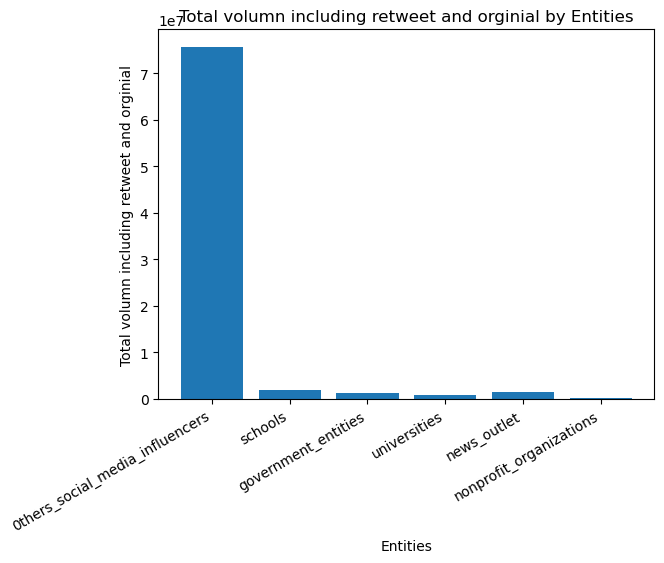

In [27]:
x = entity["entities"]
y = entity["count"]

plt.bar(x,y)
plt.ylabel('Total volumn including retweet and orginial')
plt.xlabel('Entities')
plt.title('Total volumn including retweet and orginial by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

In [28]:
# Retweet only:

In [203]:
entity_retweet = cleaned.groupby('id_str').agg(max("retweet_count").alias("retweet_count")).orderBy("retweet_count", ascending=False)
entity_retweet = cleaned.groupby('entities').count().orderBy(count("entities"), ascending=False)
entity_retweet = entity_retweet.toPandas()
# entity_retweet = entity_retweet.astype({'retweet_count':'int'})
entity_retweet

,entities,count
0,0thers_social_media_influencers,75664035
1,schools,1923196
2,news_outlet,1516533
3,government_entities,1263961
4,universities,941791
5,nonprofit_organizations,187050


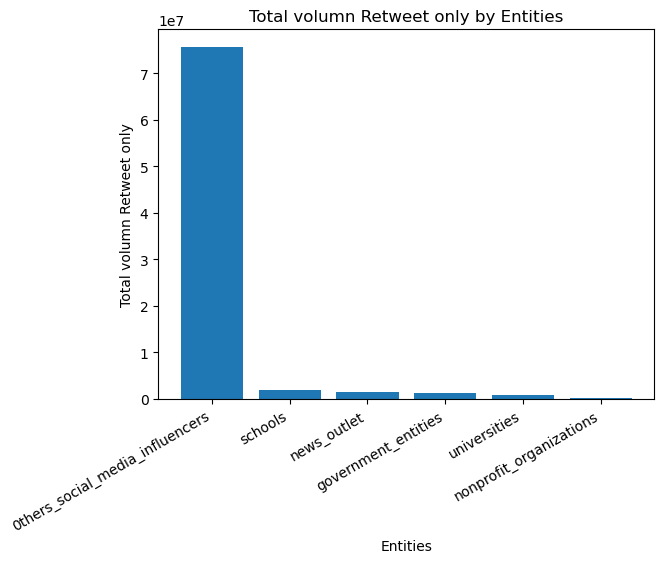

In [204]:
x = entity_retweet["entities"]
y = entity_retweet["count"]

plt.bar(x,y)
plt.ylabel('Total volumn Retweet only')
plt.xlabel('Entities')
plt.title('Total volumn Retweet only by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

In [31]:
# Original Only

In [32]:
original = original.withColumn('entities', when(original.user_description.rlike(government),'government_entities').\
                                               when(original.user_description.rlike(universities),'universities').\
                                               when(original.user_description.rlike(schools),'schools').\
                                               when(original.user_description.rlike(non_profit),'nonprofit_organizations').\
                                               when(original.user_description.rlike(news_outlet),'news_outlet').\
                                               otherwise('0thers_social_media_influencers'))
original.limit(2)

created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name,entities
Tue Jun 07 02:46:...,1534003837257846784,rt @shannonrwatts...,null,null,null,4641,false,shannonrwatts,1654569989872,Retired NC Educat...,null,Ann Franklin,afranklin1955,schools
Tue Jun 07 02:46:...,1534003837966729217,rt @katiephang: u...,null,null,null,975,false,KatiePhang,1654569990041,null,null,Scott,valvarnsen,0thers_social_med...


In [33]:
entity_original = original.groupby('entities').count()
entity_original = entity_original.toPandas()
entity_original = entity_original.astype({'count':'int'})
entity_original

,entities,count
0,0thers_social_media_influencers,49441905
1,schools,926111
2,universities,471616
3,government_entities,762710
4,news_outlet,561242
5,nonprofit_organizations,113562


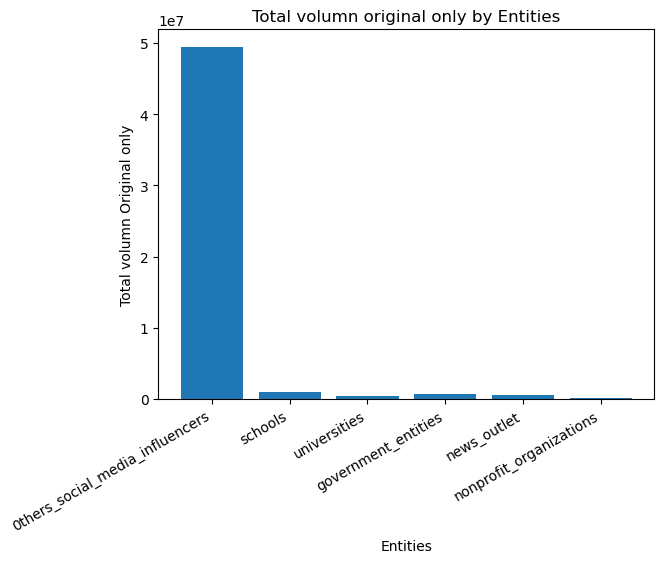

In [50]:
x = entity_original["entities"]
y = entity_original["count"]

plt.bar(x,y)
plt.ylabel('Total volumn Original only')
plt.xlabel('Entities')
plt.title('Total volumn original only by Entities')
plt.xticks(rotation=30, ha='right')
plt.show()

In [35]:
## 4. Where are these Twitterers (all of them, not just influencers) located?
#  a) Do you see any relationship between the emergence of new issues in education and progression and locations of these Twitterers?
#  b) Visualize the geographical distribution

In [36]:
# Selecting Topic: Student Loan Debt Relief

In [37]:
Debt_Relief = '|'.join(["debt(s)?", "relief", "loan", "forgive(ness)?","biden","president","tuition","reimbursement","credit","consolidate","income","salary","tax","low-income","application","Supreme ","court","block(ing)?"])
Debt_Relief
#Standardized_testing

'debt(s)?|relief|loan|forgive(ness)?|biden|president|tuition|reimbursement|credit|consolidate|income|salary|tax|low-income|application|Supreme |court|block(ing)?'

In [38]:
cleaned = cleaned.withColumn('Debt_Relief', when(cleaned.lowered_text.rlike(Debt_Relief),'Related').\
                                               otherwise('Not Related'))

In [39]:
# Related tweets / Not Related ratio:
cleaned.select('Debt_Relief').where(cleaned.Debt_Relief == "Related").count()/\
cleaned.select('Debt_Relief').where(cleaned.Debt_Relief == "Not Related").count()

0.04580198741291551

In [40]:
# Getting the top 10 locations:

In [51]:
Debt_Relief_data = cleaned.select(substring_index(cleaned.user_location, ',', 1).alias("location_cleaned")).\
where(cleaned.Debt_Relief == "Related")
Debt_Relief_data = Debt_Relief_data.groupby("location_cleaned").count().sort(desc(count("location_cleaned"))).limit(20).toPandas()
Debt_Relief_data = Debt_Relief_data.astype({'location_cleaned':'str'})
Debt_Relief_data

,location_cleaned,count
0,United States,59277
1,Lagos,28839
2,USA,27840
3,Texas,26220
4,New York,25627
5,California,24601
6,Florida,24102
7,Washington,22408
8,Nigeria,21825
9,Los Angeles,19200


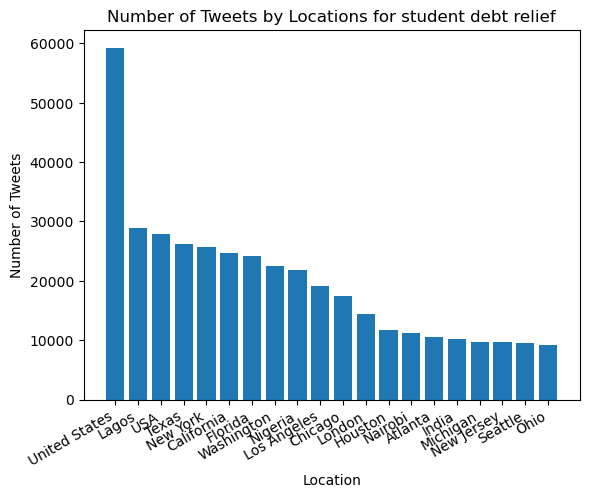

In [52]:
x = Debt_Relief_data["location_cleaned"]
y = Debt_Relief_data["count"]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Location')
plt.title('Number of Tweets by Locations for student debt relief')
plt.xticks(rotation=30, ha='right')
plt.show()

In [53]:
## 5. What are the timelines of these tweets? Do you see significant peaks and valleys?
#  a) Do you see any data collection gaps?
#  b) Plot the timelines of these tweets

In [83]:
# Convert created_at to timestamp and keep month and year for best visualization:
cleaned = cleaned.withColumn('mnth_name', substring('created_at', 5,3))
cleaned = cleaned.withColumn('year', substring('created_at', 27,4))
cleaned = cleaned.withColumn("month",from_unixtime(unix_timestamp(col("mnth_name"),'MMM'),'MM'))
cleaned = cleaned.withColumn('date', sf.concat(sf.col('month'),sf.lit(' '),sf.col('year')))
cleaned = cleaned.drop("month", "year")
cleaned = cleaned.withColumn('date_timestamp', to_timestamp("date", "MMM yyyy"))
cleaned.limit(5)

created_at,id_str,lowered_text,place_country,place_location,quoted_status_id_str,retweet_count,retweeted,retweeted_from,timestamp_ms,user_description,user_location,user_name,user_screen_name,entities,Debt_Relief,date,date_timestamp,mnth_name
Sat Jul 02 19:31:...,1543316382116610048,@sherinbanu18 yan...,null,null,null,null,null,null,1656790273585,null,null,Raj,Raj43011056,0thers_social_med...,Not Related,07 2022,null,Jul
Sat Jul 02 19:31:...,1543316383680921600,rt @lutoncpt: sou...,null,null,null,1,false,LutonCPT,1656790273958,Multi-award winni...,Bedfordshire,Teaching Talons,TeachingTalons,schools,Not Related,07 2022,null,Jul
Sat Jul 02 19:31:...,1543316385203453952,rt @hclearner1: i...,null,null,null,1071,false,hclearner1,1656790274321,null,null,Guillermo Torquato,TamashiroYokai,0thers_social_med...,Not Related,07 2022,null,Jul
Sat Jul 02 19:31:...,1543316387543777280,rt @fact: school ...,null,null,null,328,false,Fact,1656790274879,Freedom & liberty...,null,Cape Rebel,CarlMul62271699,0thers_social_med...,Not Related,07 2022,null,Jul
Sat Jul 02 19:31:...,1543316388151902210,summer school was...,null,null,18138419762,null,null,null,1656790275024,“FUCK ORGANIZED R...,Do Not Open Befor...,Jack Nasty,diegoschokehold,0thers_social_med...,Not Related,07 2022,null,Jul


In [84]:
timeline = cleaned.filter(cleaned.Debt_Relief == "Related").groupby("date").count().sort(asc("date"))

In [ ]:
timeline = timeline.toPandas()

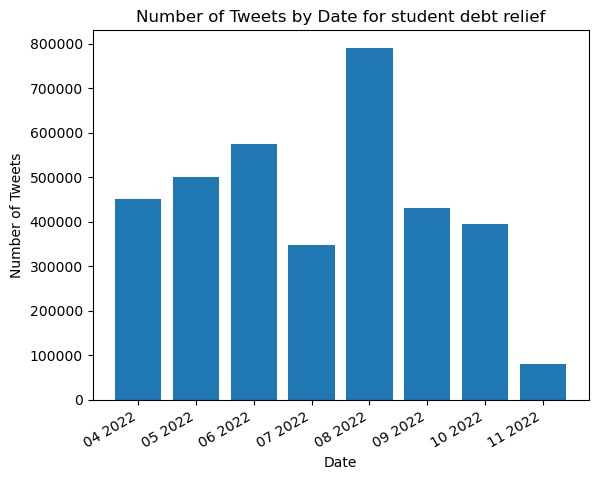

In [ ]:
x = timeline["date"]
y = timeline["count"]

plt.bar(x,y)
plt.ylabel('Number of Tweets')
plt.xlabel('Date')
plt.title('Number of Tweets by Date for student debt relief')
plt.xticks(rotation=30, ha='right')
plt.show()

In [6]:
## 6. How unique are the messages?
#  a) Are they mostly unique? Or usually people are just copy-pasting the same text?
#  b) You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity
#  c) Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)

In [7]:
## Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis
## Remember, your key objective is to analyze the profiles of Twitterers (not the actual text messages of the Tweets)
## Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [ ]:
#  a) Are they mostly unique? Or usually people are just copy-pasting the same text?
#  b) You can use something like Jaccard similarity / Cosine Similarity / Simhash / Minhash to measure uniqueness / similarity

In [10]:
# Step 1. Clean the data, remove stopwords and create index:

In [5]:
cleaned = spark.read.json("gs://msca-bdp-students-bucket/cleaned")

In [6]:
government = '|'.join(['government','agency','mayor',' senat(e)?(or)?','governor','state','gov','jurisdiction','regime',' congress','federal','law','enforcement','police'])
universities = '|'.join(['universit(y)?(ies)?','professor(s)?', 'college(s)?','research','admission','undergrad','graduate'])
schools = '|'.join(['school(s)?','middle','high','teacher(s)?','primary','elementary','secondary','college'])
non_profit ='|'.join(['non-profit','npo','ngo','Non-governmental'])
news_outlet ='|'.join( ['news','broadcast','journalis(m)?(t)?''newspaper(s)?','journal(s)?', 'tv','website(s)?'])

In [7]:
cleaned = cleaned.withColumn('entities', when(cleaned.user_description.rlike(government),'government_entities').\
                                               when(cleaned.user_description.rlike(universities),'universities').\
                                               when(cleaned.user_description.rlike(schools),'schools').\
                                               when(cleaned.user_description.rlike(non_profit),'nonprofit_organizations').\
                                               when(cleaned.user_description.rlike(news_outlet),'news_outlet').\
                                               otherwise('0thers_social_media_influencers'))

In [53]:
tweet = cleaned.select('lowered_text', "entities").limit(2000)
tweet.printSchema()

root
 |-- lowered_text: string (nullable = true)
 |-- entities: string (nullable = false)



In [54]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [55]:
tweet.limit(5).toPandas()

,lowered_text,entities
0,"rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…",0thers_social_media_influencers
1,indiana high school softball | live streaming\ntba vs fishers\neastbrook vs oak hill\ntba vs wabash\nsouth newton vs cl… https://t.co/qvvqquuog8,0thers_social_media_influencers
2,"rt @jaketapper: fifteen have been killed in a shooting at robb elementary school, according to governor greg abbott — 14 students and 1 te…",0thers_social_media_influencers
3,#uvalde is just another reason why you should home school your kids. exposing your kids to the degenerate version o… https://t.co/kiepszujtf,0thers_social_media_influencers
4,"rt @josh_moon: 14 dead elementary school kids. 14. not from crt. or ""woke"" history. which red states took great pains to ban. but from our…",0thers_social_media_influencers


In [56]:
tweet.count()

2000

In [57]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [58]:
tweet_tokens

PythonRDD[525] at RDD at PythonRDD.scala:53

In [59]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

2000

In [60]:
df_tweet

tweet,id
{rt @abc: “why ar...,0
{indiana high sch...,1
{rt @jaketapper: ...,2
{#uvalde is just ...,3
{rt @josh_moon: 1...,4
{rt @jim_jordan: ...,5
{rt @meganbang3: ...,6
{rt @jewishaction...,7
{@theusasingers m...,8
{rt @gisele239353...,9


In [63]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())
df_tweet_tokens.limit(5).toPandas()

,tweet_list_of_words,id
0,"[furious, chris, murphy, demands, answers, senators, following, texas, school]",0
1,"[indiana, high, school, softball, live, newton]",1
2,"[fifteen, killed, shooting, robb, elementary, according, governor, greg, abbott, students]",2
3,"[another, reason, home, school, exposing, kids, degenerate, version]",3
4,"[dead, elementary, school, states, took, great, pains]",4


In [64]:
df_tweet_tokens.printSchema()

root
 |-- tweet_list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [65]:
df_tweet_tokens.count()

1998

In [66]:
# Step 2. Fit countvectorizer to create word features:

In [67]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [68]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [69]:
df_tweet_vectorize.limit(5).toPandas()

,tweet_list_of_words,id,features
0,"[furious, chris, murphy, demands, answers, senators, following, texas, school]",0,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[indiana, high, school, softball, live, newton]",1,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[fifteen, killed, shooting, robb, elementary, according, governor, greg, abbott, students]",2,"(0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,"[another, reason, home, school, exposing, kids, degenerate, version]",3,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[dead, elementary, school, states, took, great, pains]",4,"(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [70]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [71]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [72]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

id,tweet,tweet_list_of_words,features,hashes,lowered_text,entities
19,{rt @justanactor:...,"[pretty, sure, at...","(2020,[0,99,185,3...","[[4.7945584E7], [...",joliet vs park ci...,0thers_social_med...
54,{biden addresses ...,"[biden, addresses...","(2020,[0,2,3,4,6,...","[[4.7945584E7], [...",me in my senior y...,0thers_social_med...
296,{rt @d0n0vaaaan: ...,"[many, school, sh...","(2020,[0,13,22,30...","[[4.7945584E7], [...",etowah vs woodsto...,0thers_social_med...
926,{@marcorubio i kn...,"[know, getting, r...","(2020,[0,3,67,155...","[[4.7945584E7], [...","finish it o, fini...",0thers_social_med...
965,{rt @weinsteinlaw...,"[congressman, rep...","(2020,[0,1,10,82,...","[[4.7945584E7], [...",@d900gt my friend...,0thers_social_med...


In [30]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [73]:
# jaccard_distance_tweet = 0.3:

In [74]:
jaccard_distance_tweet = 0.3

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [75]:
df_dups_30 = df_dups_tweet
df_dups_tweet

distCol,tweet_A,tweet_B
0.0,{rt @motivatefent...,{rt @motivatefent...
0.0,{rt @hasanthehun:...,{rt @hasanthehun:...
0.0,{rt @abc: breakin...,{rt @abc: breakin...
0.0,{rt @abc: “why ar...,{rt @abc: “why ar...
0.0,{rt @abc: breakin...,{rt @abc: breakin...
0.0,"{rt @msnbc: ""why ...","{rt @msnbc: ""why ..."
0.0,{rt @therecount: ...,{rt @therecount: ...
0.0,{rt @abc: “why ar...,{rt @abc: “why ar...
0.0,{rt @clintsmithii...,{rt @clintsmithii...
0.0,{rt @shannonrwatt...,{rt @shannonrwatt...


In [76]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_title, ': ', uniques)

Total records:  2000
Duplicate tweets based on { 0.3 } jaccard distance:  100
Unique tweets based on { 0.3 } jaccard distance:  0.3 :  1900


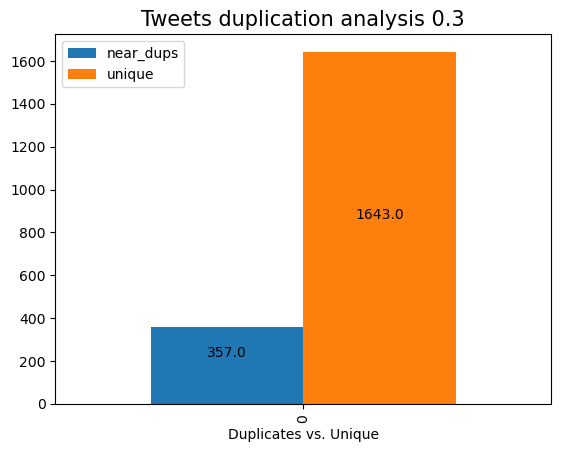

In [131]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.3', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [77]:
# jaccard_distance_tweet = 0.5:

In [78]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [79]:
df_dups_50 = df_dups_tweet
df_dups_tweet

distCol,tweet_A,tweet_B
0.0,{rt @hasanthehun:...,{rt @hasanthehun:...
0.0,{rt @abc: “why ar...,{rt @abc: “why ar...
0.0,{rt @abc: “why ar...,{rt @abc: “why ar...
0.0,{rt @mattxiv: flo...,{rt @mattxiv: flo...
0.0,{rt @motivatefent...,{rt @motivatefent...
0.0,"{rt @msnbc: ""why ...","{rt @msnbc: ""why ..."
0.0,{rt @theamandagor...,{rt @theamandagor...
0.0,{rt @jdcocchiarel...,{rt @jdcocchiarel...
0.0,{rt @therecount: ...,{rt @therecount: ...
0.0,"{rt @msnbc: ""why ...","{rt @msnbc: ""why ..."


In [80]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_title, ': ', uniques)

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  136
Unique tweets based on { 0.5 } jaccard distance:  0.3 :  1864


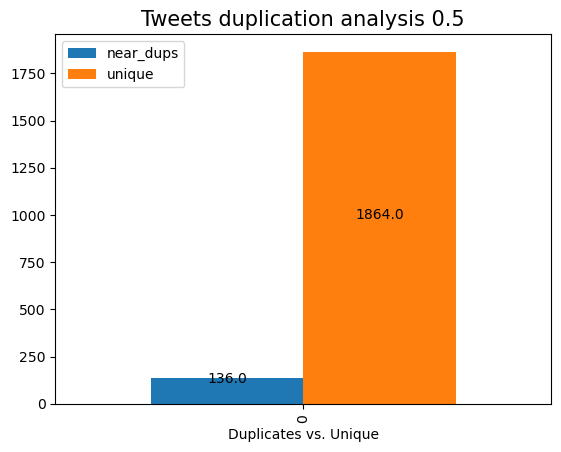

In [81]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.5', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [40]:
# jaccard_distance_tweet = 0.7:

In [82]:
jaccard_distance_tweet = 0.7

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [83]:
df_dups_50 = df_dups_tweet
df_dups_tweet

distCol,tweet_A,tweet_B
0.6666666666666667,{rt @abcpolitics:...,{rt @abc: “why ar...
0.0,{rt @hasanthehun:...,{rt @hasanthehun:...
0.6923076923076923,"{14 students, one...",{rt @lopez_wd: 14...
0.6666666666666667,{rt @npr: a shoot...,{rt @lopez_wd: 14...
0.6666666666666667,{rt @jaketapper: ...,{rt @vanityfair: ...
0.6666666666666667,{rt @abcpolitics:...,{rt @abc: “why ar...
0.4545454545454546,{rt @cspan: senat...,{rt @therecount: ...
0.6428571428571428,{rt @npr: a shoot...,{rt @fox32news: t...
0.6363636363636364,{rt @mymixtapez: ...,{this is just hor...
0.4444444444444444,{rt @nbcnews: sho...,"{14 students, one..."


In [84]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_title, ': ', uniques)

Total records:  2000
Duplicate tweets based on { 0.7 } jaccard distance:  232
Unique tweets based on { 0.7 } jaccard distance:  0.3 :  1768


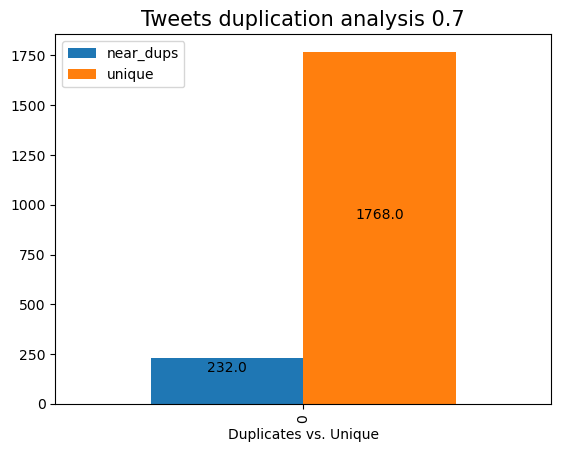

In [85]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis 0.7', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# Seeing comparisons for different jaccard_distance

In [90]:
jaccard_distance_tweet = 0.3
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_30 = df_dups_tweet

jaccard_distance_tweet = 0.5
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_50 = df_dups_tweet

jaccard_distance_tweet = 0.7
df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))
df_dups_70 = df_dups_tweet

In [92]:
df_dups_30_id = df_dups_30.select(col('tweet_A').alias('id_30_A'), col('tweet_B').alias('id_30_B'))
df_dups_50_id = df_dups_30.select(col('tweet_A').alias('id_50_A'), col('tweet_B').alias('id_50_B'))
df_dups_70_id = df_dups_70.select(col('tweet_A'), col('tweet_B'),\
                                  col('tweet_A').alias('id_70_A'), col('tweet_B').alias('id_70_B'))

print(df_dups_30_id.count())
print(df_dups_50_id.count())
print(df_dups_70_id.count())

9925


9925


26404


In [93]:
dups_combined = df_dups_70_id.join(df_dups_50_id, on=((df_dups_70_id.id_70_A == df_dups_50_id.id_50_A) & (df_dups_70_id.id_70_B == df_dups_50_id.id_50_B)), how="left_outer")\
.join(df_dups_30_id, on=((df_dups_70_id.id_70_A == df_dups_30_id.id_30_A) & (df_dups_70_id.id_70_B == df_dups_30_id.id_30_B)), how="left_outer")

In [94]:
dups_combined = dups_combined.\
withColumn("threshold_30",\
           when(col("id_30_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_50",\
           when(col("id_50_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
withColumn("threshold_70",\
           when(col("id_70_A").isNotNull(), "Duplicate").
           otherwise("Non-Dup")).\
drop('id_30_A', 'id_30_B', 'id_50_A', 'id_50_B', 'id_70_A', 'id_70_B')

In [95]:
dups_combined.limit(100).toPandas()

,tweet_A,tweet_B,threshold_30,threshold_50,threshold_70
0,"(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)","(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)",Duplicate,Duplicate,Duplicate
1,"(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)","(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)",Duplicate,Duplicate,Duplicate
2,"(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)","(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)",Duplicate,Duplicate,Duplicate
3,"(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)","(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)",Duplicate,Duplicate,Duplicate
4,"(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)","(rt @mmpadellan: another goddamn school shooting.\ntwo dead, 13 injured in uvalde, tx.\n\nhow many dead children will it take?,)",Duplicate,Duplicate,Duplicate
...,...,...,...,...,...
95,"(rt @abcpolitics: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do…,)","(rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…,)",Duplicate,Duplicate,Duplicate
96,"(rt @abcpolitics: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do…,)","(rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…,)",Duplicate,Duplicate,Duplicate
97,"(rt @abcpolitics: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do…,)","(rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…,)",Duplicate,Duplicate,Duplicate
98,"(rt @abcpolitics: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do…,)","(rt @abc: “why are you here?!""\n\na furious sen. chris murphy demands answers from senators following texas school shooting.\n\n“why do you spen…,)",Duplicate,Duplicate,Duplicate


In [8]:
### Based on the above analysis, jaccard distance (0.5) for the tweet similarity would be set as threshold = 50

In [9]:
#  c) Visualize message duplication for each group of Twitterers (government entities / health organizations / news outlets / social media influencers / other)

In [10]:
# For universities:

In [11]:
# Step 1. Clean the data, remove stopwords and create index:

In [12]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "universities").limit(2000)
tweet.printSchema()

root
 |-- lowered_text: string (nullable = true)
 |-- entities: string (nullable = false)



In [13]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [14]:
tweet.limit(5).toPandas()

,lowered_text,entities
0,"rt @warwickmansell: reading through hansard of last night's schools bill second reading, note the minister's describing new ""arm's length c…",universities
1,"rt @cspan: senator chris murphy (@chrismurphyct): ""the 14 kids dead in an elementary school in texas right now. what are we doing? what are…",universities
2,thank god conservative parents are fighting to keep “i need a new butt” out of schools. we need to let our childre… https://t.co/1znokx5zbz,universities
3,rt @goaliedad37: texas governor and ag want parents that provide gender-affirming care to have their children taken from them and the depar…,universities
4,"rt @theamandagorman: schools scared to death.\nthe truth is, one education under desks,\nstooped low from bullets;\nthat plunge when we ask\nwh…",universities


In [15]:
tweet.count()

2000

In [16]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [17]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

In [18]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())
df_tweet_tokens.limit(5).toPandas()

,tweet_list_of_words,id
0,"[would, like]",0
1,"[crazy, guys, degrees, harvard, business, school, think, raise, interest, rates, throw, bunch]",1
2,"[directed, definitely, vulnerable, nvleg, school, funding]",2
3,"[voorhees, university, emergency, management, instructor, roger, riley, says, south, carolina, residents, already]",3
4,"[voorhees, university, emergency, management, instructor, roger, riley, says, south, carolina, residents, already]",4


In [19]:
# Step 2. Fit countvectorizer to create word features:

In [20]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [21]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [22]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [23]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [24]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

22/12/05 11:55:08 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 26.0 (TID 6832) (hub-msca-bdp-dphub-students-backup-tianze-w-0.c.msca-bdp-students.internal executor 5): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.w

Py4JJavaError: An error occurred while calling o362.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 26.0 failed 10 times, most recent failure: Lost task 0.9 in stage 26.0 (TID 6940) (hub-msca-bdp-dphub-students-backup-tianze-w-0.c.msca-bdp-students.internal executor 6): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more


22/12/05 11:55:53 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 30.0 (TID 6943) (hub-msca-bdp-dphub-students-backup-tianze-sw-xq9w.c.msca-bdp-students.internal executor 1): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcess

Py4JJavaError: An error occurred while calling o362.getRowsToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 30.0 failed 10 times, most recent failure: Lost task 0.9 in stage 30.0 (TID 7012) (hub-msca-bdp-dphub-students-backup-tianze-w-0.c.msca-bdp-students.internal executor 5): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more


In [25]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [26]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

22/12/05 11:59:50 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 50.0 (TID 7537) (hub-msca-bdp-dphub-students-backup-tianze-sw-t7kh.c.msca-bdp-students.internal executor 2): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcess

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  248
Unique tweets based on { 0.5 } jaccard distance:  0.5 :  1752


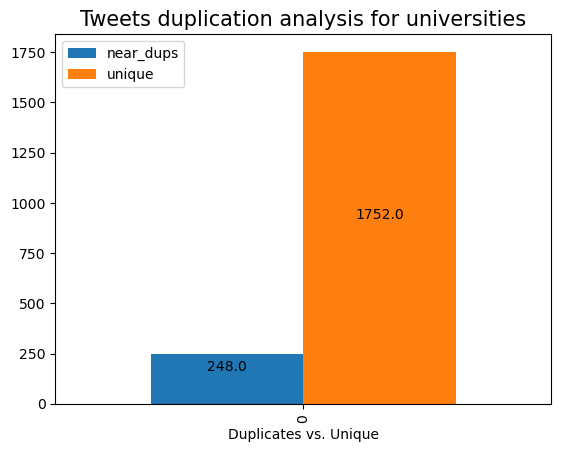

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for universities', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# For government_entities:

In [ ]:
# Step 1. Clean the data, remove stopwords and create index:

In [46]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "government_entities").limit(2000)

In [47]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [ ]:
tweet.count()

2000

In [ ]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [ ]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

In [ ]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

In [ ]:
# Step 2. Fit countvectorizer to create word features:

In [ ]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [ ]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [ ]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [ ]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

In [ ]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [ ]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B')).limit(2000)

In [ ]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

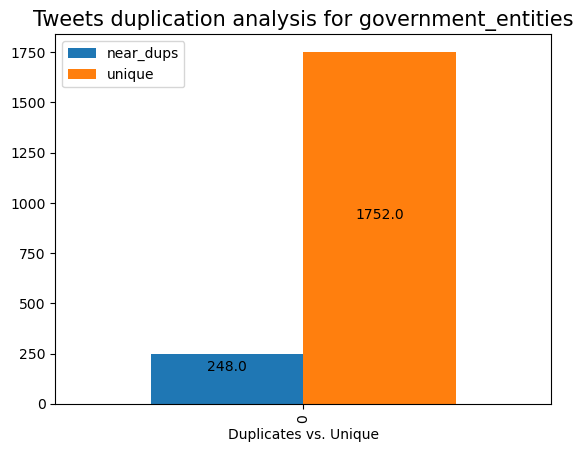

In [49]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for government_entities', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [50]:
# For schools:

In [51]:
# Step 1. Clean the data, remove stopwords and create index:

In [52]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "schools").limit(2000)

In [53]:
from pyspark.sql.functions import monotonically_increasing_id 
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [54]:
tweet.count()

2000

In [55]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [56]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])

In [57]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

In [58]:
# Step 2. Fit countvectorizer to create word features:

In [59]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [60]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [61]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [62]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [63]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
df_hashed_tweet.limit(5)

22/12/05 18:26:54 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 162.0 (TID 11755) (hub-msca-bdp-dphub-students-backup-tianze-sw-v1fx.c.msca-bdp-students.internal executor 11): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProc

id,tweet,tweet_list_of_words,features,hashes,lowered_text,entities
26,{rt @fatimasal82:...,"[northwestern, re...","(4115,[0,1,948,11...","[[4.7945584E7], [...",rt @manpree625933...,schools
29,{rt @johndsailer:...,"[game, thursday, ...","(4115,[1,18,433],...","[[7.17548289E8], ...",@bidenpriv for wh...,schools
474,{rt @dpakman: whe...,"[threat, violence...","(4115,[0,5,137,26...","[[4.7945584E7], [...",end the school ye...,schools
964,{the @newmarkjsch...,"[iyana, ontario, ...","(4115,[420],[1.0])","[[7.26127252E8], ...",like i requested ...,schools
1677,{rt @tinywienerba...,"[afraid, forgot, ...","(4115,[676,1236,3...","[[4.55668122E8], ...",@tressiemcphd tha...,schools


In [64]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [65]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [66]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

22/12/05 18:29:38 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 209.0 (TID 13498) (hub-msca-bdp-dphub-students-backup-tianze-w-1.c.msca-bdp-students.internal executor 13): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcesso

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  187
Unique tweets based on { 0.5 } jaccard distance:  0.5 :  1813


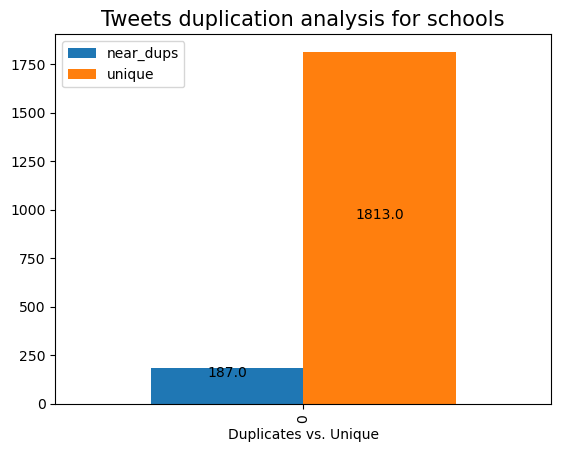

In [67]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for schools', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [68]:
# For nonprofit_organizations:

In [85]:
# Step 1. Clean the data, remove stopwords and create index:

In [103]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "universities").limit(2000)

In [104]:
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [105]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [106]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

2000

In [107]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

In [108]:
# Step 2. Fit countvectorizer to create word features:

In [109]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [110]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [111]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [112]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [113]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")

22/12/05 18:47:36 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 437.0 (TID 20234) (hub-msca-bdp-dphub-students-backup-tianze-sw-txfd.c.msca-bdp-students.internal executor 30): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWritePro

Py4JJavaError: An error occurred while calling o1843.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 437.0 failed 10 times, most recent failure: Lost task 0.9 in stage 437.0 (TID 20337) (hub-msca-bdp-dphub-students-backup-tianze-sw-2zxs.c.msca-bdp-students.internal executor 19): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more


22/12/05 18:47:53 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 441.0 (TID 20344) (hub-msca-bdp-dphub-students-backup-tianze-sw-h3hf.c.msca-bdp-students.internal executor 17): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWritePro

Py4JJavaError: An error occurred while calling o1843.getRowsToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 441.0 failed 10 times, most recent failure: Lost task 0.9 in stage 441.0 (TID 20447) (hub-msca-bdp-dphub-students-backup-tianze-sw-cgmp.c.msca-bdp-students.internal executor 26): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2304)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2252)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2252)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1124)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1124)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2491)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2433)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2422)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:505)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:508)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.lang.IllegalArgumentException: requirement failed: Must have at least 1 non zero entry.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.MinHashLSHModel.hashFunction(MinHashLSH.scala:61)
	at org.apache.spark.ml.feature.LSHModel.$anonfun$transform$1(LSH.scala:101)
	... 15 more


In [114]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [115]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [116]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

# print ('Total records: ', records)
# print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
# print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

Total records:  2000
Duplicate tweets based on { 0.5 } jaccard distance:  79
Unique tweets based on { 0.5 } jaccard distance:  0.5 :  1921


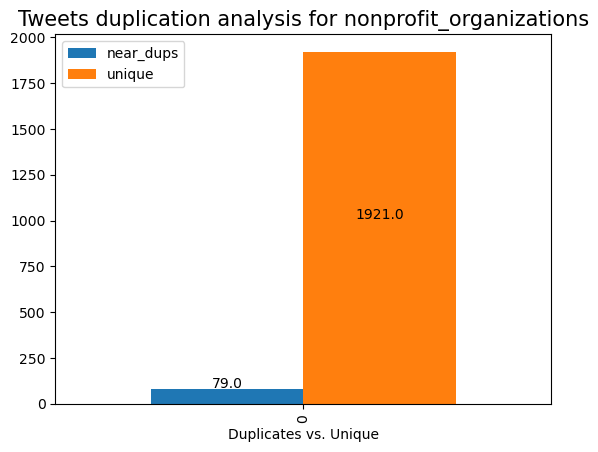

In [117]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for nonprofit_organizations', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [ ]:
# For news_outlet:

In [134]:
# Step 1. Clean the data, remove stopwords and create index:

In [135]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "news_outlet").limit(2000)

In [136]:
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [137]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [138]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
df_tweet.count()

2000

In [139]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())

In [140]:
# Step 2. Fit countvectorizer to create word features:

In [141]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [142]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [143]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [144]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [145]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
# df_hashed_tweet.limit(5)

In [146]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [147]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [148]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

# print ('Total records: ', records)
# print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
# print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

22/12/05 19:01:57 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 599.0 (TID 25262) (hub-msca-bdp-dphub-students-backup-tianze-sw-v1fx.c.msca-bdp-students.internal executor 56): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProc

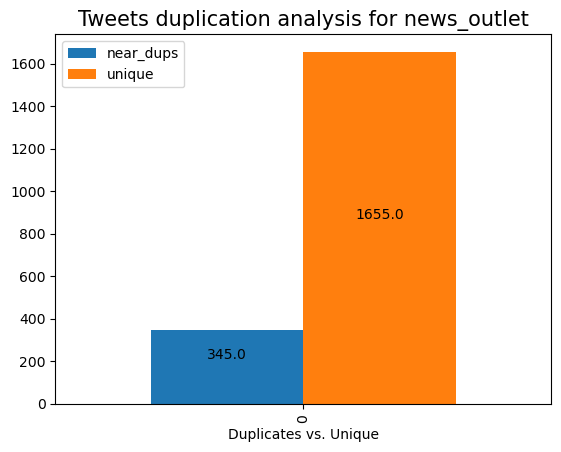

In [149]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for news_outlet', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [150]:
# For 0thers_social_media_influencers:

In [151]:
# Step 1. Clean the data, remove stopwords and create index:

In [180]:
tweet = cleaned.select('lowered_text', "entities").filter(col("entities") == "0thers_social_media_influencers").limit(2000)

In [181]:
entities_ids = tweet.select("*").withColumn("id", monotonically_increasing_id())

In [182]:
tweet = tweet.rdd.map(lambda x : x['lowered_text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tweet_tokens = tweet\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if x.isalnum()])\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [183]:
row = Row('tweet',"entities")
df_tweet = tweet.map(row).zipWithIndex().toDF(['tweet','id'])
# df_tweet.count()

In [184]:
df_tweet_tokens = spark.createDataFrame(tweet_tokens, ["tweet_list_of_words",'id'])

#Drop records with no tokens
df_tweet_tokens = df_tweet_tokens.where(col('tweet_list_of_words').getItem(0).isNotNull())
# df_tweet_tokens.limit(5).toPandas()

In [185]:
# Step 2. Fit countvectorizer to create word features:

In [186]:
tweet_vectorize = CountVectorizer(inputCol="tweet_list_of_words", outputCol="features", minDF=1.0)
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [187]:
df_tweet_vectorize = tweet_vectorize.fit(df_tweet_tokens).transform(df_tweet_tokens)

In [188]:
# Step 3. Fit MinHashLSH to create hash table:
## Note: Adding more hash tables will increase the accuracy at the expense of training time

In [189]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_tweet_vectorize)
df_hashed = mh.fit(df_tweet_vectorize).transform(df_tweet_vectorize)

In [190]:
df_hashed_tweet = df_tweet.join(df_hashed, "id", how = 'left')
df_hashed_tweet = df_hashed_tweet.join(entities_ids, "id", how = "left")
# df_hashed_tweet.limit(5)

In [191]:
# Step 4. Establish similarity threshold and return near-duplicate records:
## Note: we are joining dataframe to itself to get near-duplicate pairs

In [192]:
jaccard_distance_tweet = 0.5

df_dups_tweet = model.approxSimilarityJoin(df_hashed_tweet, df_hashed_tweet, jaccard_distance_tweet).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col('datasetA.tweet').alias('tweet_A'),
            col('datasetB.tweet').alias('tweet_B'))

In [193]:
records = df_hashed_tweet.count()
dups = df_dups_tweet.select('tweet_A').distinct().count()
uniques = records - dups

# print ('Total records: ', records)
# print ('Duplicate tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', dups)
# print ('Unique tweets based on {', jaccard_distance_tweet, '} jaccard distance: ', jaccard_distance_tweet, ': ', uniques)

22/12/05 19:05:18 WARN org.apache.spark.scheduler.TaskSetManager: Lost task 0.0 in stage 749.0 (TID 30158) (hub-msca-bdp-dphub-students-backup-tianze-sw-g1t1.c.msca-bdp-students.internal executor 63): org.apache.spark.SparkException: Failed to execute user defined function(LSHModel$Lambda$3746/524475704: (struct<type:tinyint,size:int,indices:array<int>,values:array<double>>) => array<struct<type:tinyint,size:int,indices:array<int>,values:array<double>>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:157)
	at org.apache.spark.shuffle.ShuffleWriteProc

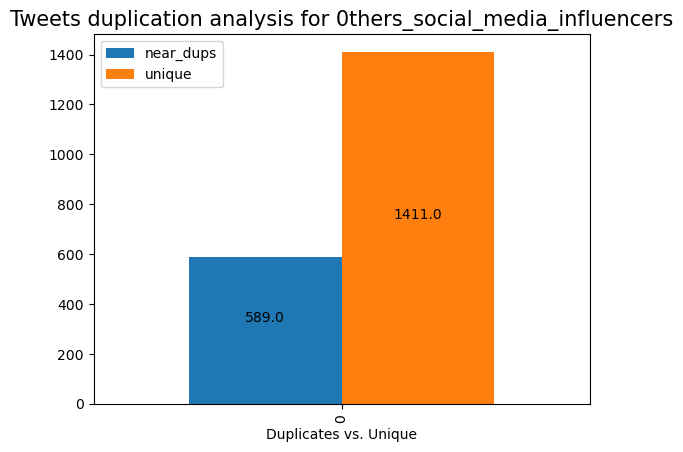

In [194]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Tweets duplication analysis for 0thers_social_media_influencers', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [205]:
import datetime
import pytz

datetime.datetime.now(pytz.timezone('US/Central')).strftime("%a, %d %B %Y %H:%M:%S")

'Tue, 06 December 2022 15:40:19'